# Brazilian congress analyzer

The Brazilian congress is composed of two chambers: the Senate and the Chamber of Deputies. The multi-party system leads to the formation of complex coalitions.

The goal of this project is to uncover underlying voting patterns among the members of the Chamber of Deputies in 2024. We will use unsupervised machine learning algorithms (PCA and K-means) to group deputies into three clusters based purely on their votes, hypothesizing that these clusters align with the common Left, Right and Center ideological groupings.

The data was obtained from the official Dados Abertos portal of the Chamber of Deputies: https://dadosabertos.camara.leg.br/". It consists of votings from January 1, 2024 to December 31, 2024.

**We aim to answer the following questions:**

* Can deputies be grouped into distict clusters based on 2024 voting?
* How interpretable are these clusters, do they align with known party positions?
* What is the ideological composition of the parties (based on clusters)?





In [ ]:
#importing the required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# 1. Loading the data

In [ ]:
home_folder = ''
data_file = 'total_data_2024.csv'
data_path = os.path.join(home_folder, data_file)
df = pd.read_csv(data_path)
df.head()

,id_votacao,data,descricao,deputado_id,deputado_nome,partidoSigla,uf,voto
0,2367548-7,2024-02-20,REQ 1884/2023,220664,Guilherme Uchoa,PSB,PE,Sim
1,2367548-7,2024-02-20,REQ 1884/2023,220531,Gilvan Maximo,REPUBLICANOS,DF,Sim
2,2367548-7,2024-02-20,REQ 1884/2023,74317,Júlio Cesar,PSD,PI,Sim
3,2367548-7,2024-02-20,REQ 1884/2023,143632,Domingos Neto,PSD,CE,Sim
4,2367548-7,2024-02-20,REQ 1884/2023,74161,Reginaldo Lopes,PT,MG,Sim


Let us rename the columns from Portuguese to English.

In [ ]:
# Rename columns from Portuguese to English
column_mapping = {
    'deputado_id': 'deputy_id',
    'deputado_nome': 'deputy_name',
    'partidoSigla': 'partyAcronym',
    'id_votacao': 'vote_id',
    'voto': 'vote',
    'descricao': 'description',
    'voto_encoded': 'vote_encoded',
    'data': 'date',
    'uf': 'state'
}
df = df.rename(columns=column_mapping)
df.head()

,vote_id,date,description,deputy_id,deputy_name,partyAcronym,state,vote
0,2367548-7,2024-02-20,REQ 1884/2023,220664,Guilherme Uchoa,PSB,PE,Sim
1,2367548-7,2024-02-20,REQ 1884/2023,220531,Gilvan Maximo,REPUBLICANOS,DF,Sim
2,2367548-7,2024-02-20,REQ 1884/2023,74317,Júlio Cesar,PSD,PI,Sim
3,2367548-7,2024-02-20,REQ 1884/2023,143632,Domingos Neto,PSD,CE,Sim
4,2367548-7,2024-02-20,REQ 1884/2023,74161,Reginaldo Lopes,PT,MG,Sim


In [ ]:
df.shape

(115328, 8)

**Exploring the types of votes**

In [ ]:
print(df['vote'].unique())

['Sim' 'Não' 'Artigo 17' 'Abstenção' 'Obstrução']


# 2. Data Preprocessing and Feature Engineering

**Enconding votes**

We will map 'Sim' (Yes) to 1, 'Não' (No) to -1. The other types of votes, 'Artigo 17', 'Abstenção', 'Obstrução', we will treat as 'Others' and map to 0.

In [ ]:
vote_mapping = {
    'Sim': 1,
    'Não': -1,
    'Abstenção': 0,
    'Obstrução': 0,
    'Artigo 17': 0,
}
df['vote_encoded'] = df['vote'].map(vote_mapping)


df.head()

,vote_id,date,description,deputy_id,deputy_name,partyAcronym,state,vote,vote_encoded
0,2367548-7,2024-02-20,REQ 1884/2023,220664,Guilherme Uchoa,PSB,PE,Sim,1
1,2367548-7,2024-02-20,REQ 1884/2023,220531,Gilvan Maximo,REPUBLICANOS,DF,Sim,1
2,2367548-7,2024-02-20,REQ 1884/2023,74317,Júlio Cesar,PSD,PI,Sim,1
3,2367548-7,2024-02-20,REQ 1884/2023,143632,Domingos Neto,PSD,CE,Sim,1
4,2367548-7,2024-02-20,REQ 1884/2023,74161,Reginaldo Lopes,PT,MG,Sim,1


**Create a deputy x vote matrix**

This matrix will allow us to group deputies based on their voting patterns. The rows correspond to the identifiers of each deputy and the columns to the votings.

In [ ]:
votes_matrix = df.pivot_table(
        index=['deputy_id', 'deputy_name', 'partyAcronym', 'state'],
        columns='vote_id',
        values='vote_encoded'
    )
votes_matrix.fillna(0, inplace=True)
votes_matrix.head()

,,,vote_id,1197773-140,1212491-84,1301141-69,1548579-186,1548579-194,1594768-93,1672576-221,2076875-108,2079477-63,2079700-179,...,537377-101,537377-104,537377-88,537377-97,541855-97,559138-237,559138-241,565397-185,945492-147,945492-151
deputy_id,deputy_name,partyAcronym,state,,,,,,,,,,,,,,,,,,,,,
62881,Danilo Forte,UNIÃO,CE,-1.0,0.0,0.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,1.0
66385,Julio Arcoverde,PP,PI,-1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0
66828,Fausto Pinato,PP,SP,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,0.0
68720,Fábio Henrique,UNIÃO,SE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69871,Bacelar,PV,BA,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0,0.0,1.0


In [ ]:
votes_matrix.shape

(584, 426)

The dimensions of the matrix corresponds to the data of 584 deputies on 426 votings.

# 3. Dimension reduction with PCA

Think of the vote matrix as coordinates for each deputy on a certain space, each line corresponds to the coordinates of the respective deputy. To make clustering easier, PCA reduces the dimension of this 'deputy space'. The way it does that is by finding the main axes of variation in voting behavior, essentially picking the most important directions.

Note on Scaling: PCA is sensitive to feature scaling. Since our encoded votes (-1, 0, 1) are already on a comparable scale, explicit scaling (StandardScaler) might not be strictly necessary or could even alter the interpretation slightly. However, if some votes had different ranges for some reason, scaling would be important.


Shape after PCA: (584, 20)


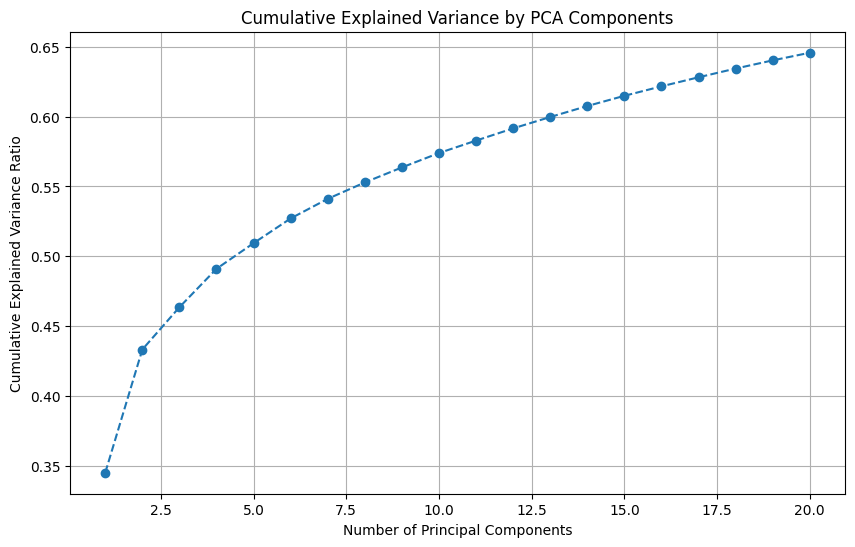


Variance explained by first 2 components: 0.43
Variance explained by first 20 components: 0.65
Using first 20 PCA components for clustering.


In [ ]:
# Apply PCA
# Decide on the number of components. Start with a reasonable number (e.g., 10-50)
# or analyze explained variance.
n_components_pca = 20 # Example: Start with 20 components
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(votes_matrix)

print(f"\nShape after PCA: {X_pca.shape}")

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_pca + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

print(f"\nVariance explained by first 2 components: {cumulative_variance[1]:.2f}")
print(f"Variance explained by first {n_components_pca} components: {cumulative_variance[-1]:.2f}")

# Choose number of components for clustering (e.g., explaining ~70-80% variance, or use first few)
# Let's use the first 2 components for visualization, but maybe more for clustering.
n_components_for_clustering = 20 # Adjust based on the plot
X_pca_clustering = X_pca[:, :n_components_for_clustering]
print(f"Using first {n_components_for_clustering} PCA components for clustering.")

# 4. Clustering deputies with K-means

We will group deputies into 3 clusters based on their voting patterns (represented by PCA components), using the K-means algorithm. K-Means was chosen for its simplicity and efficiency. It aims to partition deputies into k clusters such that deputies within a cluster are closer (in the PCA space) to the cluster's centroid than to other centroids. We specified k=3 based on the project goal of identifying Left/Center/Right groupings.


K-Means clustering completed.

Cluster Distribution:
Cluster 2: 301 deputies
Cluster 1: 124 deputies
Cluster 0: 159 deputies



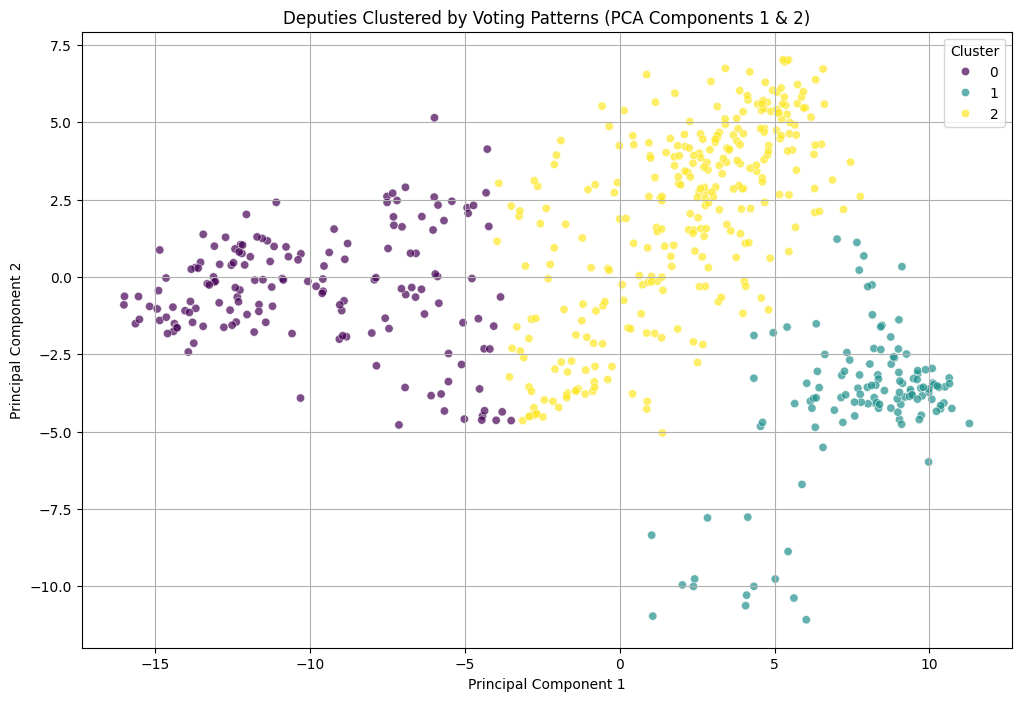

In [ ]:
# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # n_init= 10 to mitigate sensitivity to initial centroid placement
cluster_labels = kmeans.fit_predict(X_pca_clustering)

# Add cluster labels back to the deputy information
votes_matrix['cluster_raw'] = cluster_labels

print("\nK-Means clustering completed.")
cluster_distribution = "\nCluster Distribution:\n"
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    cluster_distribution += f"Cluster {cluster}: {count} deputies\n"

print(cluster_distribution)

# Visualize the clusters using the first two PCA components
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=votes_matrix['cluster_raw'],
    palette='viridis', # Choose a palette
    alpha=0.7
)
plt.title('Deputies Clustered by Voting Patterns (PCA Components 1 & 2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# Analyze party composition within each cluster
party_cluster_counts = votes_matrix.groupby(['cluster_raw', 'partyAcronym']).size().unstack(fill_value=0)

print("\nParty counts per raw cluster:")
party_cluster_counts


Party counts per raw cluster:


partyAcronym,AVANTE,CIDADANIA,MDB,NOVO,PCdoB,PDT,PL,PODE,PP,PRD,PSB,PSD,PSDB,PSOL,PT,PV,REDE,REPUBLICANOS,SOLIDARIEDADE,UNIÃO
cluster_raw,,,,,,,,,,,,,,,,,,,,
0,0,2,4,4,0,0,99,2,13,3,0,4,3,0,0,0,0,4,0,21
1,2,0,2,0,7,8,0,0,1,0,14,1,1,13,68,4,1,0,1,1
2,5,3,43,0,0,13,10,17,44,3,0,50,10,0,4,2,0,47,6,44


**Interpretation step**

This is a potentially subjective step. K-means provides numerical labels, translating these to 'Left', 'Right' and 'Center' requires external knowledge and analysis of cluster composition.

Since Cluster 1 is dominated by PT and PSOL we will map it to 'Left', since Cluster 0 is dominated by 'PL' and 'PP' we will map it to 'Right'.


In [ ]:
cluster_mapping = {
    1: 'Left',
    2: 'Center',
    0: 'Right'
}
print("\nCluster interpretation mapping:")
print(cluster_mapping)


Cluster interpretation mapping:
{1: 'Left', 2: 'Center', 0: 'Right'}



Cluster distribution with ideological labels:
cluster_ideology
Center    301
Right     159
Left      124
Name: count, dtype: int64


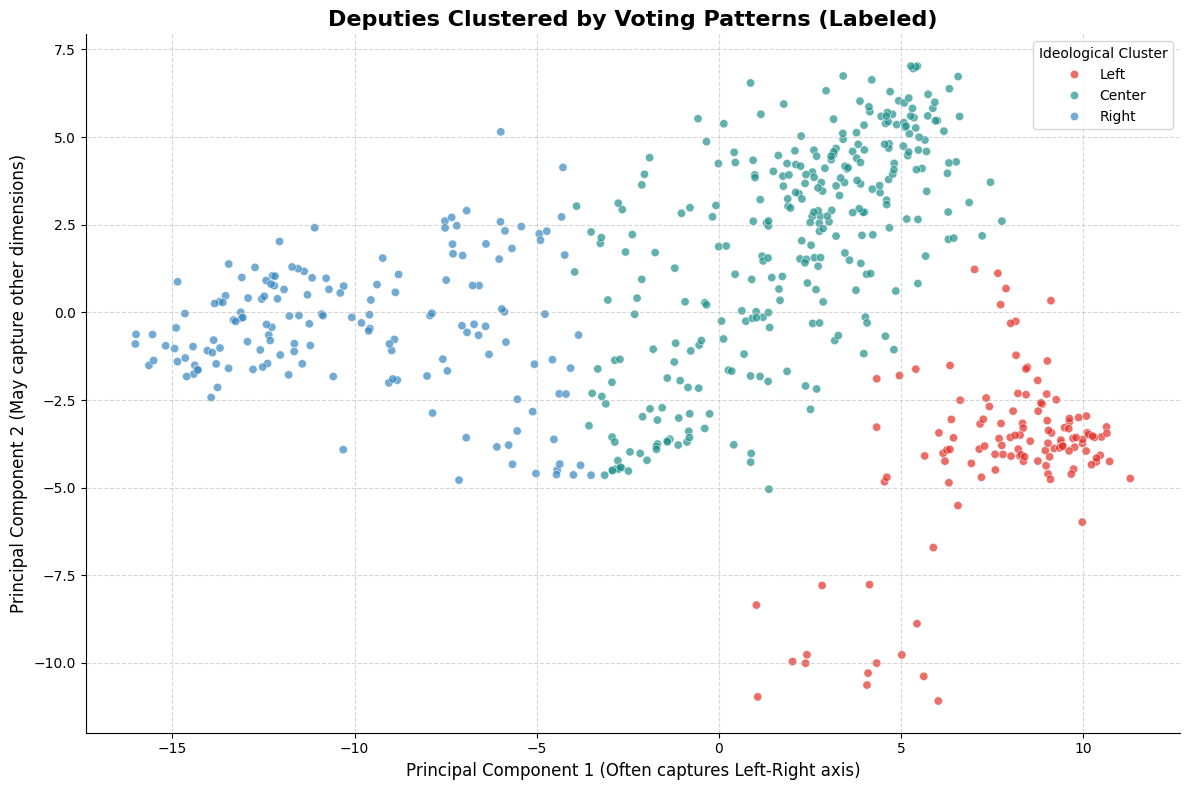

In [ ]:
# Apply the meaningful labels
votes_matrix['cluster_ideology'] = votes_matrix['cluster_raw'].map(cluster_mapping)

# Verify the mapping
print("\nCluster distribution with ideological labels:")
print(votes_matrix['cluster_ideology'].value_counts())

# Visualize again with meaningful labels
#setting plotting colors
left_color = sns.color_palette("Reds", 8)[5]  # 6th color from "Reds" (darker)
center_color = sns.color_palette("viridis", 3)[1]  # Greenish from "viridis"
right_color = sns.color_palette("Blues", 8)[5]  # 6th color from "Blues" (darker)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=votes_matrix['cluster_ideology'],
    hue_order=['Left', 'Center', 'Right'], # Ensure consistent order
    palette={'Left': left_color, 'Center': center_color, 'Right': right_color}, # Assign colors
    alpha=0.7
)
plt.title('Deputies Clustered by Voting Patterns (Labeled)', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1 (Often captures Left-Right axis)', fontsize=12)
plt.ylabel('Principal Component 2 (May capture other dimensions)', fontsize=12)
plt.legend(title='Ideological Cluster', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid
sns.despine()  # Remove top and right spines for a cleaner look
plt.tight_layout()
plt.show()


# 5. Party Cohesion Analysis
We will Measure how uniformly members of the same party vote. Since the party REDE has only one member it will not appear in this analysis.

Method: Calculate the percentage of members voting with the party majority on each non-unanimous vote, then average across votes.




Party Cohesion Scores:
               cohesion_score
NOVO                 0.991837
PCdoB                0.989845
PT                   0.985191
PSOL                 0.982905
PSB                  0.963134
PV                   0.958519
PDT                  0.942457
REPUBLICANOS         0.938783
PL                   0.921661
AVANTE               0.902407
PP                   0.895433
PSD                  0.878316
PSDB                 0.876852
SOLIDARIEDADE        0.874935
PODE                 0.867655
MDB                  0.861685
CIDADANIA            0.848105
UNIÃO                0.848081
PRD                  0.797690


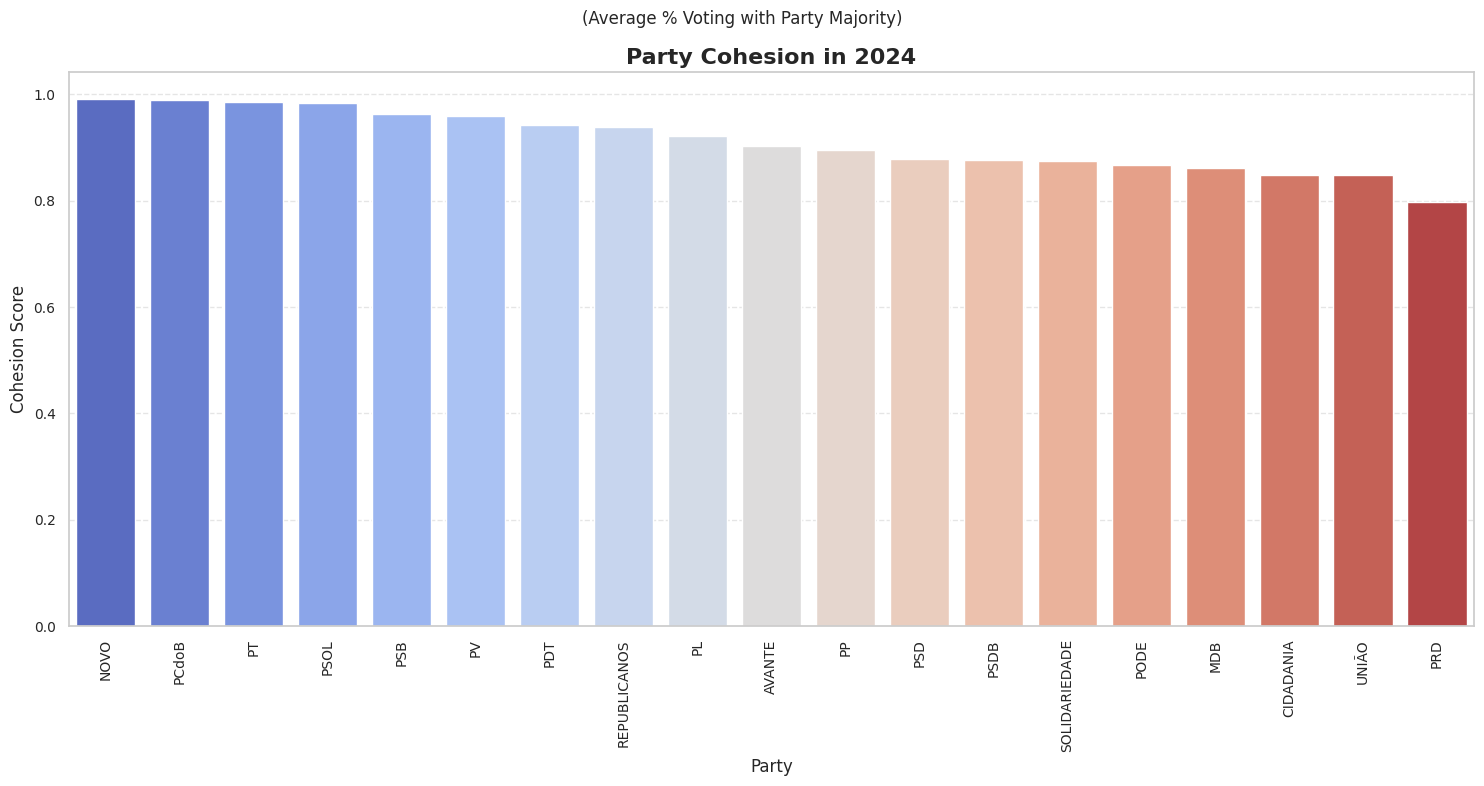

In [ ]:
# Function to calculate party cohesion
def calculate_party_cohesion(party_votes):
    cohesion_scores = []
    # Iterate through each vote (column)
    for vote_col in party_votes.columns:
        # Exclude non-vote info if columns were added
        if vote_col in ['cluster_raw', 'cluster_ideology']: continue

        votes_on_bill = party_votes[vote_col].dropna() # Ignore NaNs if any remain
        votes_on_bill = votes_on_bill[votes_on_bill != 0] # Consider only Yes/No votes

        if len(votes_on_bill) < 2: # Not enough party members voted or only neutral votes
            continue

        # Find majority position (1 or -1)
        vote_counts = votes_on_bill.value_counts()
        if len(vote_counts) == 0: continue # No Sim/Nao votes

        majority_vote = vote_counts.idxmax()
        # Count members voting with majority
        num_with_majority = (votes_on_bill == majority_vote).sum()
        # Cohesion for this bill = % voting with majority
        cohesion = num_with_majority / len(votes_on_bill)
        cohesion_scores.append(cohesion)

    # Average cohesion across all relevant votes
    if not cohesion_scores:
        return np.nan # No valid votes found for cohesion calculation
    return np.mean(cohesion_scores)

# Calculate cohesion for each party
# Use vote_matrix_filled which has party in the index
parties = votes_matrix.index.get_level_values('partyAcronym').unique()
cohesion_results = {}

for party in parties:
    party_data = votes_matrix[votes_matrix.index.get_level_values('partyAcronym') == party]
    if len(party_data) > 1: # Need at least 2 members to calculate cohesion meaningfully
      cohesion_results[party] = calculate_party_cohesion(party_data)
    else:
      cohesion_results[party] = np.nan # Assign NaN for single-member "parties" or small groups

party_cohesion_df = pd.DataFrame.from_dict(cohesion_results, orient='index', columns=['cohesion_score'])
party_cohesion_df = party_cohesion_df.dropna().sort_values('cohesion_score', ascending=False)

print("\nParty Cohesion Scores:")
print(party_cohesion_df)

# Visualize Party Cohesion
# Set the style and context for the plot
sns.set_theme(style="whitegrid")  # Use a whitegrid theme
plt.figure(figsize=(15, 8))  # Set an appropriate figure size

# Create the bar plot with custom colors and styling
sns.barplot(
    x=party_cohesion_df.index,
    y=party_cohesion_df['cohesion_score'],
    palette='coolwarm'  # Use a diverging color palette for cohesion scores
)

# Add title and labels with formatting
plt.title('Party Cohesion in 2024', fontsize=16, fontweight='bold')  # Main title
plt.suptitle('(Average % Voting with Party Majority)', fontsize=12)  # Subtitle
plt.xlabel('Party', fontsize=12)
plt.ylabel('Cohesion Score', fontsize=12)

# Customize tick labels for better readability
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels if needed
plt.yticks(fontsize=10)

# Add a light grid for better visual organization
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid to the y-axis

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

The result shows that NOVO, PCdoB, PT and PSOL are highly cohesive while UNIAO and PRD appears more fragmented. This might reflect strong party discipline or internal consensus (high cohesion) versus internal divisions or strategic voting (low cohesion).

#7. Party Composition Analysis (Based on Clusters)

Goal: Show the breakdown of each party according to the Left, Center, Right clusters derived from voting patterns.

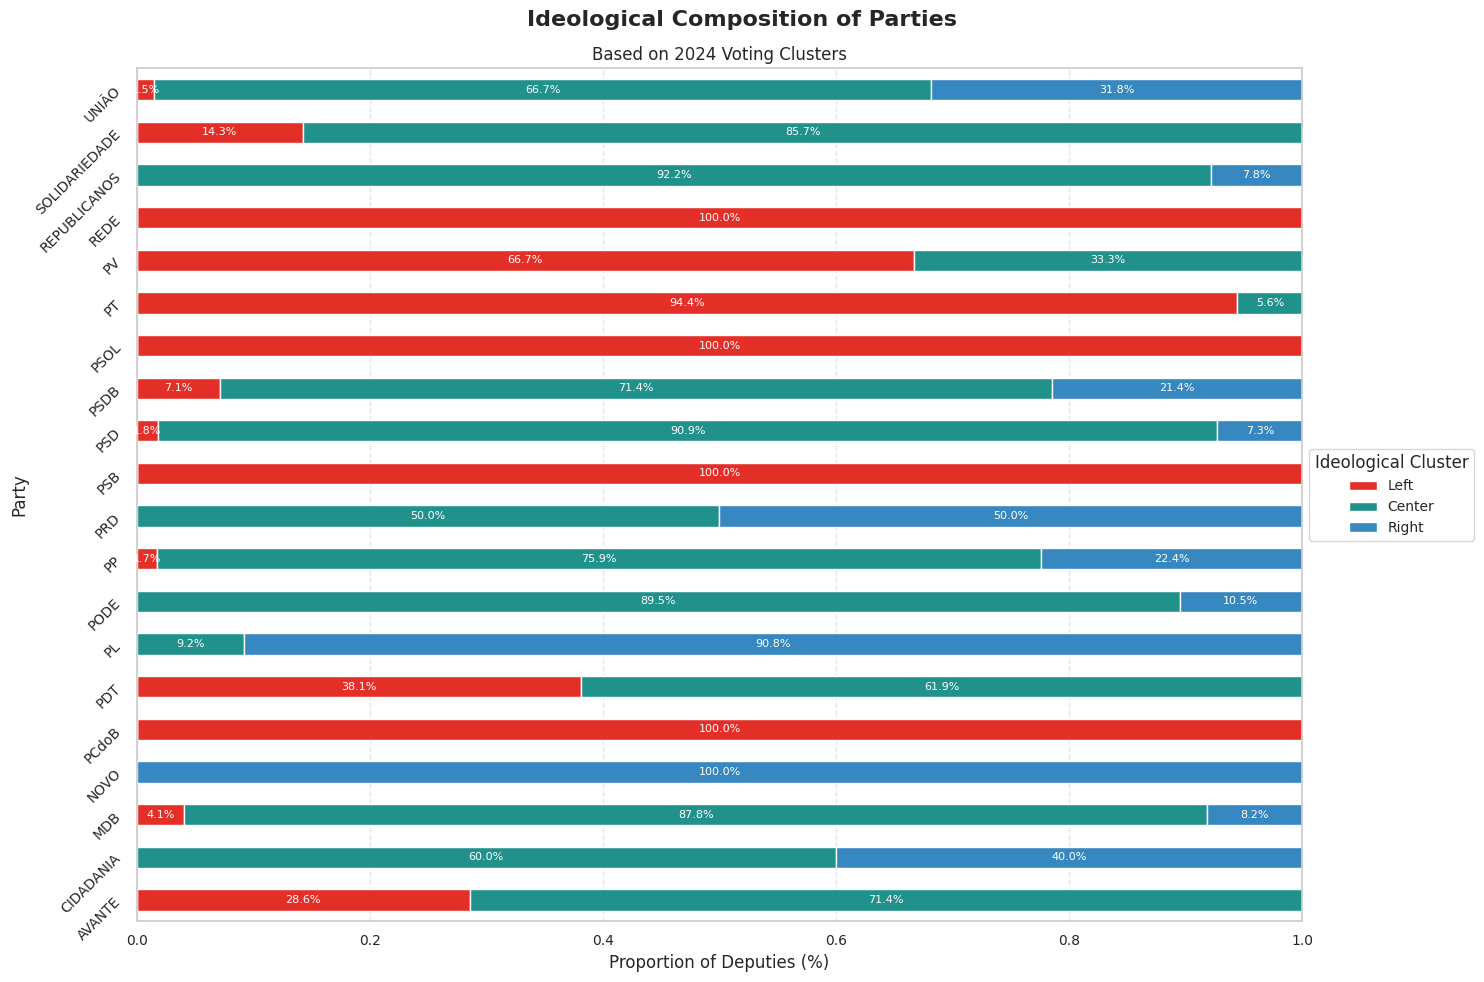

In [ ]:
# Calculate party composition based on assigned ideological clusters
party_composition = votes_matrix.groupby('partyAcronym')['cluster_ideology'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure all clusters are present as columns, even if a party has 0 members in one
for cluster_label in ['Left', 'Center', 'Right']:
    if cluster_label not in party_composition.columns:
        party_composition[cluster_label] = 0

# Reorder columns for consistency
party_composition = party_composition[['Left', 'Center', 'Right']]

# print("\nParty Composition based on Ideological Clusters (%):")
# print((party_composition * 100).round(1))

# Visualize Party Composition - Stacked Bar Chart
#setting plotting colors
left_color = sns.color_palette("Reds", 8)[5]  # 6th color from "Reds" (darker)
center_color = sns.color_palette("viridis", 3)[1]  # Greenish from "viridis"
right_color = sns.color_palette("Blues", 8)[5]  # 6th color from "Blues" (darker)colors = [left_color, center_color, right_color]

colors = [left_color, center_color, right_color]

# Plot the stacked bar chart
party_composition.plot(
    kind='barh',
    stacked=True,
    figsize=(15, 10),  # Adjust figure size as needed
    color=colors
)


# Iterate through each bar (party) and add annotations
for i, party in enumerate(party_composition.index):
    cumulative_proportion = 0
    for j, (cluster, proportion) in enumerate(party_composition.loc[party].items()):
        if proportion > 0.01:
            plt.text(cumulative_proportion + proportion / 2, i,
                     f'{proportion * 100:.1f}%',
                     ha='center', va='center', color='white', fontsize=8)

        cumulative_proportion += proportion


plt.suptitle('Ideological Composition of Parties', fontsize=16, fontweight='bold')  # Main title
plt.title('Based on 2024 Voting Clusters', fontsize=12)  # Subtitle
plt.ylabel('Party', fontsize=12)
plt.xlabel('Proportion of Deputies (%)', fontsize=12)  # Add "%" to the x-axis label
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=45, ha='right')  # Rotate party names if needed
plt.legend(title='Ideological Cluster', fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add a light grid to the x-axis
plt.xlim(0, 1)  # Adjust if necessary to ensure bars reach the end
plt.tight_layout()
plt.show()

Comparing to the cohesion graph we can see that parties that lean strongly to the left or to the right have a tendency to be more cohesive. This observation suggests that:

* Stronger ideological alignment: Parties on the extremes might have a clearer and more defined ideology, leading to greater agreement among members on policy issues and therefore more cohesive voting patterns.

* Stricter party discipline: Parties on the extremes might enforce stricter rules and expectations for how members should vote, potentially leading to punishments or consequences for deviating from the party line. This can contribute to higher cohesion.


We can also analyse the cluster composition by state. This might suggest ideological tendencies of the  voters in the respective states.

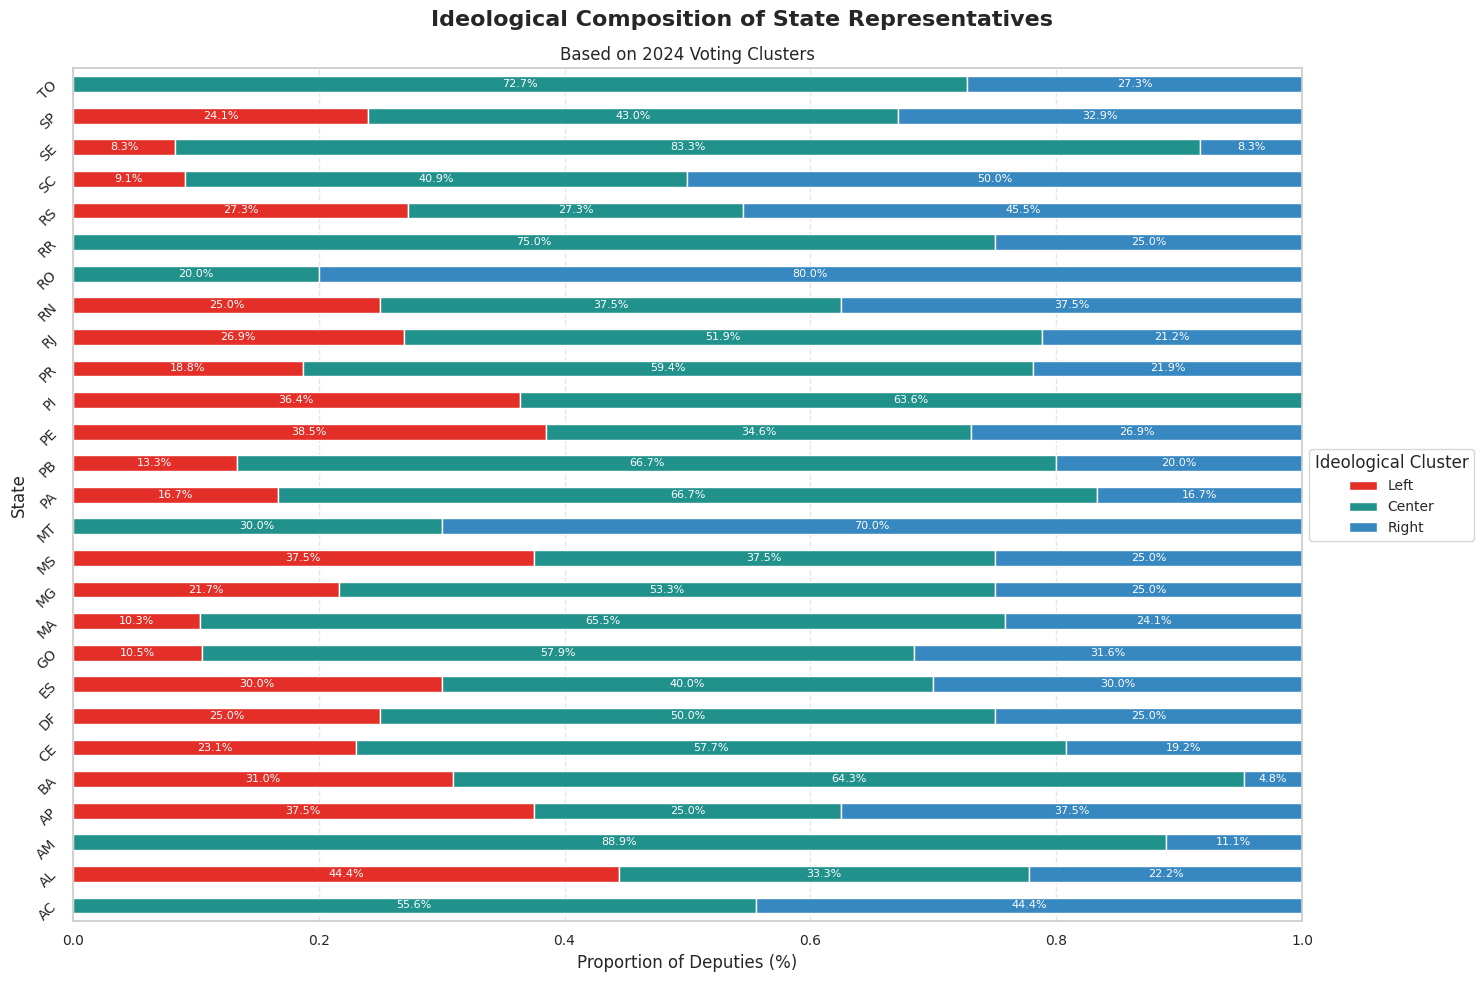

In [ ]:
# Calculate state composition based on assigned ideological clusters
state_composition = votes_matrix.groupby('state')['cluster_ideology'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure all clusters are present as columns, even if a party has 0 members in one
for cluster_label in ['Left', 'Center', 'Right']:
    if cluster_label not in state_composition.columns:
        state_composition[cluster_label] = 0

# Reorder columns for consistency
state_composition = state_composition[['Left', 'Center', 'Right']]

# print("\nState Composition based on Ideological Clusters (%):")
# print((state_composition * 100).round(1))

# Visualize State Composition - Stacked Bar Chart
sns.set_theme(style="whitegrid")


#setting plotting colors
left_color = sns.color_palette("Reds", 8)[5]  # 6th color from "Reds" (darker)
center_color = sns.color_palette("viridis", 3)[1]  # Greenish from "viridis"
right_color = sns.color_palette("Blues", 8)[5]  # 6th color from "Blues" (darker)

colors = [left_color, center_color, right_color]

state_composition.plot(
    kind='barh',
    stacked=True,
    figsize=(15, 10),  # Adjusted figure size
    color=colors
)

# Iterate through each bar (state) and add annotations
for i, state in enumerate(state_composition.index):
    cumulative_proportion = 0  # Track the cumulative proportion for bar positioning
    for j, (cluster, proportion) in enumerate(state_composition.loc[state].items()):
        if proportion > 0.01: # Only label bars larger than 1%
            # Place text in the center of each section of the bar
            plt.text(cumulative_proportion + proportion / 2, i,
                     f'{proportion * 100:.1f}%',
                     ha='center', va='center', color='white', fontsize=8)

        cumulative_proportion += proportion  # Add for the next section


plt.suptitle('Ideological Composition of State Representatives', fontsize=16, fontweight='bold')  # Main title
plt.title('Based on 2024 Voting Clusters', fontsize=12)  # Subtitle
plt.ylabel('State', fontsize=12)
plt.xlabel('Proportion of Deputies (%)', fontsize=12)  # Add "%" to the x-axis label
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=45, ha='right')  # Adjust font size and rotation of state names
plt.legend(title='Ideological Cluster', fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add a light grid to the x-axis
plt.xlim(0, 1)  # Adjust 1.05 if necessary to ensure bars reach the end
plt.tight_layout()
plt.show()

Finally, let us see how much each party contributes to each cluster.

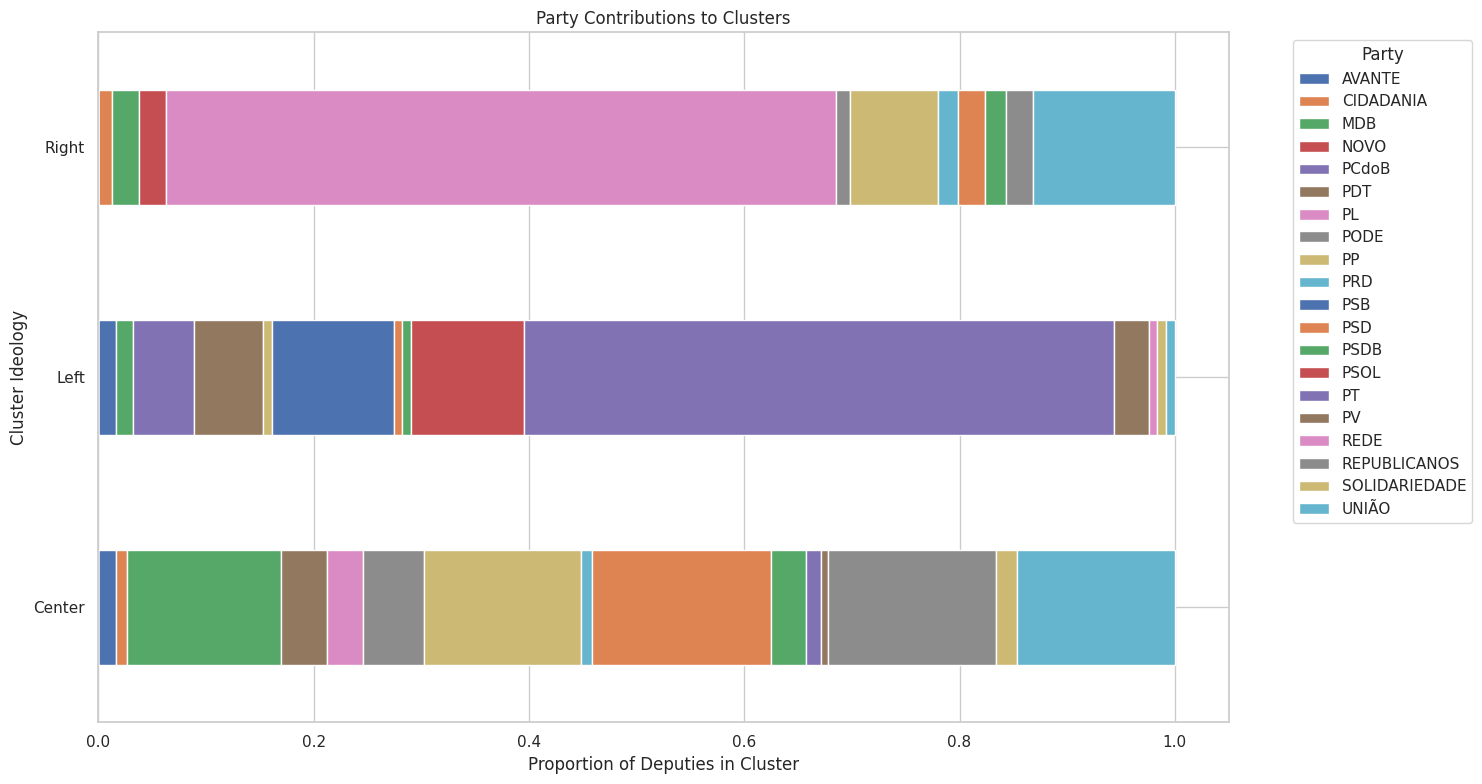

In [ ]:
# Reset the index to make 'partyAcronym' a regular column
votes_matrix = votes_matrix.reset_index()

# Calculate party contributions to clusters
cluster_party_composition = votes_matrix.groupby('cluster_ideology')['partyAcronym'].value_counts(normalize=True).unstack(fill_value=0)

# Plotting the stacked bar chart
cluster_party_composition.plot(kind='barh', stacked=True, figsize=(15, 8))
plt.title('Party Contributions to Clusters')
plt.xlabel('Proportion of Deputies in Cluster')
plt.ylabel('Cluster Ideology')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This graph shows that while PL and PT dominate the right and left, respectively, the center is much more diverse.

# Conclusion

1. Can deputies be grouped into distinct clusters based on 2024 voting?

Yes, deputies can be effectively grouped into distinct clusters based on their voting patterns. Using Principal Component Analysis (PCA) to reduce the dimensionality of the voting data and K-means clustering with k=3, we identified three clusters that broadly align with left, center, and right ideological groupings. This suggests underlying patterns in voting behavior that reflect broader political ideologies.

2. How interpretable are these clusters, do they align with known party positions?

The clusters are largely interpretable and generally align with known party positions. Cluster 1, primarily composed of PT and PSOL members, is identified as the "Left." Cluster 0, dominated by PL and PP, is identified as the "Right." Cluster 2, encompassing a more diverse range of parties, represents the "Center." This alignment supports the validity of using unsupervised learning to uncover ideological groupings based on voting data.

3. What is the ideological composition of the parties (based on clusters)?

The ideological composition of parties varies, reflecting the diversity of the Brazilian political landscape. Some parties, like PT and PSOL, demonstrate strong left-leaning tendencies, while others, like PL and PP, lean heavily towards the right. Parties like UNIAO and PSD exhibit a more mixed composition, with members spread across the left, center, and right clusters. This analysis provides a quantitative basis for understanding the ideological spectrum of Brazilian political parties based on their deputies' voting behavior.

**Further observations:**

* Parties with stronger ideological leanings (left or right) tend to exhibit higher levels of cohesion, indicating greater internal agreement and party discipline.
* The "Center" cluster comprises a more heterogeneous mix of parties, suggesting a less unified ideological stance.
* State-level analysis reveals variations in ideological representation, highlighting potential regional differences in political preferences.

**Limitations:**
* While the clusters align with general ideological groupings, individual deputies may not perfectly fit within these categories.
* The analysis relies on a simplified model (PCA and K-means) and might not capture all nuances of political behavior.

* The choice of k=3 clusters was imposed but exploring a higher number of clusters could reveal additional patterns.

**Implications:**

These results highlight the strategic importance of alliances with "Center" parties for the government ('Left') to achieve legislative success in the Brazilian Congress. The analysis suggests that the government has actively pursued and maintained these alliances throughout 2024, given the limited number of deputies in the "Left" cluster and the considerable influence wielded by the "Center" and "Right" clusters. This reliance on cross-party collaboration is likely to remain crucial for the government's ability to pass legislation and advance its agenda. This might explain the lower levels of cohesion observed for "Center" parties, as they might participate in alliances for specific votings, potentially deviating from a unified ideological stance.

**Future projects:**

Analyzing how the alliances change throughout the year, for instance if there are center parties that align with the left for a portion of the year and then turn to the opposition.

